In [325]:
!pip install scipy

Alumno: Marianela Pi
Materia: Sistemas de información Geoespacial para el Análisis Social C23

# Trabajo practico integrador
 
El trabajo práctico integrador se basa en la construcción de zonas homogéneas (clústers) para la ciudad de Pergamino.

Determine su unidad geográfica de análisis: Barrios o Radios Censales 2010

Considere la notebook de la clase 6 como ejemplo para dotar a su unidad de análisis con los siguientes tipos de variables:
<ul>
<li>Variable de distancia: Calcule la distancia de su unidad de análisis al objeto geográfico de interés.</li>
<li>Variable de conteo: Construya una variable de cantidad de objetos geográficos sobre su unidad de análisis.</li>
<li>Variables Censo 2010: Seleccione las variables INDEC que le resulten de interés.</li>
</ul>

Realice una construcción de zonas homogéneas aplicando K-means o algún otro algoritmo de clusterización. Considere la notebook de la clase 7 para este punto

Genere una visualización y argumente los resultados




In [326]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
from owslib.wfs import WebFeatureService
import matplotlib.pyplot as plt
# bibliotecas 
from shapely.ops import nearest_points
from shapely.geometry import LineString
import geopandas as gpd
from shapely.wkt import loads
from pyproj import CRS
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import numpy as np


# URL del servicio WFS que deseas consultar
wfs_url = "http://ide.pergamino.gob.ar:8080/geoserver/wfs" # IGN

# Solicitud GetCapabilities al servicio WFS
wfs = WebFeatureService(wfs_url, version='1.0.0')

# Listado de capas publicadas
list(wfs.contents)

['publico:rampas_acceso_veredas',
 'publico:aeropuertos',
 'publico:agencias_de_viaje',
 'publico:agencias_gubernamentales',
 'publico:aglomerados_urbanos',
 'publico:alcantarillas_vialidad',
 'publico:altura_de_calle',
 'publico:arbolado',
 'publico:areas_fiscalizadas_construcciones',
 'publico:areas_programaticas_desarrollo_social',
 'publico:areas_programaticas_salud',
 'publico:barrido_y_limpieza',
 'publico:barrios',
 'publico:banados',
 'publico:beata_crescencia_perez',
 'publico:bibliotecas',
 'publico:bocas_pago_tasas',
 'publico:bomberos',
 'publico:calidad_vivienda',
 'publico:callejero',
 'publico:callejero_listado',
 'publico:camaras_seguridad',
 'publico:camaras_y_radares',
 'publico:caps',
 'publico:carteles_viales',
 'publico:catastro_chacra',
 'publico:catastro_circunscripcion',
 'publico:catastro_fraccion',
 'publico:catastro_manzana',
 'publico:catastro_medida_lado',
 'publico:catastro_parcela',
 'publico:catastro_quinta',
 'publico:catastro_seccion',
 'publico:catast

### Seleccionamos la variable
En este caso elegimos la variable Gastronomía

In [327]:
# Radios censales de gastronomia
gastronomia = gpd.read_file(wfs.getfeature(typename=['gastronomia']))
gastronomia.head()

gml_id                         nombre                direccion  \
0   gastronomia.1  Helens Guest House Restaurant              Florida 514   
1  gastronomia.40             La Mulita Parrilla     Dr Alem y Pueyrredon   
2   gastronomia.3                      Prudencio   Prudencio Gonzalez 965   
3   gastronomia.4                    Burger Shop              Alberti 378   
4  gastronomia.30         Catalina Parilla Libre  Ruta 8 y José Hernández   

       telefono                        mail  \
0   2477-424752  helensguesthouse@gmail.com   
1  02477-416900                         NaN   
2   2477-413795                         NaN   
3   2477-419688                         NaN   
4   2477-425766                         NaN   

                                                 web         tipo  \
0                        www.helensguesthouse.com.ar  Restaurante   
1                                                NaN  Restaurante   
2                                                NaN  Restaurante   
3  https://www.facebook.com/burgershoppergamino?f...  Restaurante   
4                                                NaN  Restaurante   

  observaciones instagram                     geometry  
0           NaN       NaN  POINT (-60.57349 -33.89803)  
1           NaN       NaN  POINT (-60.57157 -33.89446)  
2           NaN       NaN  POINT (-60.56600 -33.90033)  
3           NaN       NaN  POINT (-60.56897 -33.89372)  
4           NaN       NaN  POINT (-60.55261 -33.89976)

In [328]:
# Gastronomia
gastronomia = gpd.read_file(wfs.getfeature(typename=['gastronomia']))
# Verificamos si tiene crs asociados
print(gastronomia.crs)

None


#### Seteamos la columna geometry

Al no tener crs asociados ajustamos la proyección de los datos geoespaciales primero al sistema de referencia global (WGS 84) y luego a una proyección local específica (Gauss-Krüger Faja 5) para que coincidan con la región de interés y se puedan realizar análisis geoespaciales precisos en esa área.

In [329]:
# WGS84 - Seteo
gastronomia = gastronomia.set_crs('EPSG:4326') 

# Se transforma a Gauss Kruger Faja 5 para trabajar en un sistema proyectado ()
gastronomia = gastronomia.to_crs('EPSG:5347')


In [330]:
gastronomia.head()

gml_id                         nombre                direccion  \
0   gastronomia.1  Helens Guest House Restaurant              Florida 514   
1  gastronomia.40             La Mulita Parrilla     Dr Alem y Pueyrredon   
2   gastronomia.3                      Prudencio   Prudencio Gonzalez 965   
3   gastronomia.4                    Burger Shop              Alberti 378   
4  gastronomia.30         Catalina Parilla Libre  Ruta 8 y José Hernández   

       telefono                        mail  \
0   2477-424752  helensguesthouse@gmail.com   
1  02477-416900                         NaN   
2   2477-413795                         NaN   
3   2477-419688                         NaN   
4   2477-425766                         NaN   

                                                 web         tipo  \
0                        www.helensguesthouse.com.ar  Restaurante   
1                                                NaN  Restaurante   
2                                                NaN  Restaurante   
3  https://www.facebook.com/burgershoppergamino?f...  Restaurante   
4                                                NaN  Restaurante   

  observaciones instagram                         geometry  
0           NaN       NaN  POINT (5446954.991 6249467.135)  
1           NaN       NaN  POINT (5447130.585 6249864.436)  
2           NaN       NaN  POINT (5447648.975 6249216.586)  
3           NaN       NaN  POINT (5447369.907 6249947.413)  
4           NaN       NaN  POINT (5448887.243 6249286.141)

In [331]:
mapa = gastronomia.explore(
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="gastronomia",  # Nombre del layer en el control de capas
)

mapa # Mostrar mapa de los lugares gastronomicos

Realizamos un buffer de 300 metros sobre los centros gastronómicos para conocer su área de influencia

In [332]:
# Creación del buffer
# Radio de influencia en unidades del sistema de coordenadas de la capa la cual la trabajamos en metros
gastronomia_buffer = gastronomia.buffer(300) 

# Comprobación del objeto resultado
gastronomia_buffer.head()

0    POLYGON ((5447254.991 6249467.135, 5447253.546...
1    POLYGON ((5447430.585 6249864.436, 5447429.140...
2    POLYGON ((5447948.975 6249216.586, 5447947.530...
3    POLYGON ((5447669.907 6249947.413, 5447668.463...
4    POLYGON ((5449187.243 6249286.141, 5449185.798...
dtype: geometry

In [333]:
# Conversión en un GeoDataFrame
# Indicamos
gastronomia_buffer = gpd.GeoDataFrame(geometry=gastronomia_buffer, crs=gastronomia.crs) 

In [334]:
mapa = gastronomia_buffer.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Área Influencia",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # Agregar control de capas al mapa

mapa # Mostrar mapa

### Disolver
Este algoritmo toma una capa vectorial de polígonos y borrará los límites comunes de los polígonos adyacentes. Se pueden especificar uno o más atributos para disolver características pertenecientes a la misma clase (con el mismo valor para los atributos especificados), o bien todos los objetos espaciales se pueden disolver en uno solo.

Apliquemos este algoritmos sobre el área de influencia.


In [335]:
# Aplicamos un disolver sin agrupamiento por columna
gastronomia_dissolve = gastronomia_buffer.dissolve()

# Comprobación del objeto resultado
gastronomia_dissolve

geometry
0  MULTIPOLYGON (((5445884.291 6247142.531, 54458...

In [336]:
mapa = gastronomia_dissolve.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Área Influencia Disuelta",  # Nombre del layer en el control de capas
)

mapa # Mostrar mapa

### Polígonos de Voronoi

Aplicaremos esta transformación para conocer el centro gastronómico más cercano de acuerdo a la ubicación.

In [337]:
# Extraemos coordenadas X e Y de la geometría porque es la forma que lo requiere scipy.spatial
x_coords = gastronomia.geometry.x
y_coords = gastronomia.geometry.y

# Creamos un DataFrame con las coordenadas
coords_gastronomia = pd.DataFrame({'X': x_coords, 'Y': y_coords})

# Creamos polígonos de Voronoi
vor = Voronoi(coords_gastronomia)

# Capturamos los vertices de cada polígono
voronoi_polygons = []
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        vertices = [vor.vertices[i] for i in region]
        voronoi_polygons.append(Polygon(vertices))

# Creamos un GeoDataFrame con los polígonos de Voronoi
poligonos_voronoi = gpd.GeoDataFrame(geometry=voronoi_polygons)
poligonos_voronoi = poligonos_voronoi.set_crs(gastronomia.crs) # Utilizamos la capa que le da origen

# Mostramos el GeoDataFrame resultante
mapa = poligonos_voronoi.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Área Influencia Disuelta",  # Nombre del layer en el control de capas
)

mapa # Mostrar mapa

### Cortar
Cortamos los polígonos de Voronoi con el área de influencia para enmarcar nuestro problema al área de estudio con el método `overlay`.

In [338]:
# Cortamos la capa Voronoi con el área de influencia disuelta
resultado_corte = gpd.overlay(poligonos_voronoi, gastronomia_dissolve, how='intersection')

# Mostramos el GeoDataFrame resultante
mapa = resultado_corte.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Área Influencia Disuelta",  # Nombre del layer en el control de capas
)

gastronomia.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'blue', # Color de borde
                    fillColor='blue', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="gastronomia",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # use folium to add layer control

mapa # Mostrar mapa

### Centroides

Cargamos los datos geoespaciales de los barrios, calculamos los centroides de los barrios y luego lo  mostramos en un mapa interactivo con opciones para mostrar u ocultar las capas de los barrios y los centroides. Los barrios se muestran en rojo y los centroides en negro.

In [339]:
# Barrios
barrios = gpd.read_file(wfs.getfeature(typename=['barrios']))
barrios = barrios.set_crs('EPSG:5347') # Se comprobó que no tenía CRS asignado, se verificaron las coordenadas y se asigna Gauss-Kruguer Faja 5 para tener un sistema proyectado

# Calculos de centroides
barrios_centroides = barrios.geometry.centroid

# Mostramos el GeoDataFrame resultante
mapa = barrios.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Barrios",  # Nombre del layer en el control de capas
)

barrios_centroides.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'black', # Color de borde
                    fillColor='black', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="Centroide",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # use folium to add layer control

mapa # Mostrar mapa

## Combinaciones

### Unión 1 a 1
Este algoritmo toma una capa vectorial de entrada y crea una nueva capa que contiene los atributos de la capa original junto a los atributos de los objetos superpuestos. Los atributos adicionales y sus valores se toman de una segunda capa vectorial. Se aplica un criterio espacial para seleccionar los valores de la segunda capa que se agregan a cada entidad de la primera capa.

In [340]:
# Realizar la unión espacial por superposición (contención)
union_1a1 = resultado_corte.sjoin(gastronomia, how="inner", predicate='contains')

# Mostramos el GeoDataFrame resultante
mapa = union_1a1.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Área Influencia Disuelta",  # Nombre del layer en el control de capas
)

mapa # Mostrar mapa

In [341]:
# Mostramos el GeoDataFrame resultante
mapa = barrios.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Barrios",  # Nombre del layer en el control de capas
)

gastronomia.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'blue', # Color de borde
                    fillColor='blue', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="Gastronomia",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # use folium to add layer control

mapa # Mostrar mapa

In [342]:
# Realizar la unión espacial por superposición (contención)
union = barrios.sjoin(gastronomia, how='inner', predicate='contains')
union.head()

gml_id_left  id nombre_left tipo_left    area  \
0  barrios.fid--2e0e67b8_18a6c17855a_76c2   1      Centro   Abierto  222.25   
0  barrios.fid--2e0e67b8_18a6c17855a_76c2   1      Centro   Abierto  222.25   
0  barrios.fid--2e0e67b8_18a6c17855a_76c2   1      Centro   Abierto  222.25   
0  barrios.fid--2e0e67b8_18a6c17855a_76c2   1      Centro   Abierto  222.25   
0  barrios.fid--2e0e67b8_18a6c17855a_76c2   1      Centro   Abierto  222.25   

  ordenanza                            delimitacion distrito  \
0   8850-18  Alsina, Colón, Arroyo Pergamino, Rocha   centro   
0   8850-18  Alsina, Colón, Arroyo Pergamino, Rocha   centro   
0   8850-18  Alsina, Colón, Arroyo Pergamino, Rocha   centro   
0   8850-18  Alsina, Colón, Arroyo Pergamino, Rocha   centro   
0   8850-18  Alsina, Colón, Arroyo Pergamino, Rocha   centro   

   proy_habitantes_2020  proy_densidad_2020  ...  index_right  \
0                 15204               68.41  ...          125   
0                 15204               68.41  ...          131   
0                 15204               68.41  ...           76   
0                 15204               68.41  ...           48   
0                 15204               68.41  ...           41   

      gml_id_right           nombre_right             direccion     telefono  \
0  gastronomia.128                  La Fe      San Nicolás 1201       414308   
0  gastronomia.134                  Lilos         Dr. Alem 1001       444144   
0   gastronomia.79             Dry Tragos       General Paz 638  2477-531513   
0   gastronomia.39              Bar Fidel       General Paz 631  2477-444005   
0   gastronomia.49  Taco de Reina Vintage  11 de Septiembre 352  2477-414702   

  mail  web   tipo_right observaciones  \
0  NaN  NaN    Heladeria           NaN   
0  NaN  NaN    Heladeria           NaN   
0  NaN  NaN    Resto-bar           NaN   
0  NaN  NaN    Resto-bar           NaN   
0  NaN  NaN  Restaurante           NaN   

                                           instagram  
0  helaadoslafe                                  ...  
0  lilos.artesanal                               ...  
0                                                NaN  
0                                                NaN  
0                                                NaN  

[5 rows x 23 columns]

El resultado es un nuevo conjunto de datos que muestra la relación entre los barrios y los lugares gastronómicos en términos de superposición espacial. La salida es un DataFrame que contiene información sobre los barrios y los lugares gastronómicos que están contenidos dentro de cada barrio. Cada fila de este DataFrame representa una unión entre un barrio y un lugar gastronómico.

## Conteo

Realizamos un conteo de la cantidad de lugares gastronómicos por barrio y luego fusiona esta información con el GeoDataFrame de los barrios en Pergamino.

In [343]:
# Agrupamos la tabla de unión por el identificador único del barrio
conteo_por_barrio = union.groupby('id').size().reset_index(name='cantidad_gastronomia') #Size devuelve el numero de filas (Pandas)

# Fusionar el recuento con el GeoDataFrame de barrios
barrios = barrios.merge(conteo_por_barrio, on='id', how='left')
barrios.head()

gml_id  id               nombre     tipo  \
0  barrios.fid--2e0e67b8_18a6c17855a_76c2   1               Centro  Abierto   
1  barrios.fid--2e0e67b8_18a6c17855a_76c3  18              Kennedy  Abierto   
2  barrios.fid--2e0e67b8_18a6c17855a_76c4   5               Trocha  Abierto   
3  barrios.fid--2e0e67b8_18a6c17855a_76c5  22     María Crescencia  Abierto   
4  barrios.fid--2e0e67b8_18a6c17855a_76c6  36  Martín M. de Güemes  Abierto   

     area ordenanza                                       delimitacion  \
0  222.25   8850-18             Alsina, Colón, Arroyo Pergamino, Rocha   
1   87.32   8850-18  Arroyo Pergamino, Dr Balbín, Dr. F. Auil, Fron...   
2   37.90   8850-18  Yrigoyen, Rocha, Arroyo Pergamino, vías FFCC e...   
3   63.53   8850-18  Tropero Chavero, Hernández, límite sur parcela...   
4   75.26   8850-18  Esquivel, vías FFCC ex Mitre, Arroyo Pergamino...   

  distrito  proy_habitantes_2020  proy_densidad_2020  color_id  localidad  \
0   centro                 15204               68.41         3  Pergamino   
1      sur                  1440               16.49         7  Pergamino   
2     este                  2209               58.28         4  Pergamino   
3     este                   433                6.82         1  Pergamino   
4    oeste                  1433               19.04         3  Pergamino   

                                            geometry  cantidad_gastronomia  
0  MULTIPOLYGON (((5445892.146 6249178.833, 54459...                  85.0  
1  MULTIPOLYGON (((5447894.022 6248360.572, 54479...                   NaN  
2  MULTIPOLYGON (((5447676.723 6249783.332, 54480...                   7.0  
3  MULTIPOLYGON (((5448899.657 6248695.493, 54495...                   NaN  
4  MULTIPOLYGON (((5445388.914 6249467.632, 54452...                   NaN

In [344]:
# Mostramos el GeoDataFrame resultante
mapa = barrios.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Barrios",  # Nombre del layer en el control de capas
)

gastronomia.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'blue', # Color de borde
                    fillColor='blue', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="gastronomia",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # use folium to add layer control

mapa # Mostrar mapa

In [345]:
# Completamos los datos faltantes en la columna 'cantidad_gastronomia' con 0
barrios['cantidad_gastronomia'].fillna(0, inplace=True)

## Cálculo de distancias

Realizamos un cálculo de distancias entre los barrios de Pergamino y los cursos de agua más cercanos.
El resultado de este análisis es la distancia entre los objetos más cercanos de 2 capas.

In [346]:
# Cursos de agua
cursos_de_agua = gpd.read_file(wfs.getfeature(typename=['cursos_de_agua']))
cursos_de_agua = cursos_de_agua.set_crs('EPSG:5347') # Se comprobó que no tenía CRS asignado, se verificaron las coordenadas y se asigna Gauss-Kruguer Faja 5 para tener un sistema proyectado

from shapely.ops import nearest_points
# Crear una lista para almacenar las distancias al río más cercano
distancias_al_rio = []

# Iterar sobre los barrios y calcular la distancia al río más cercano
for idx, barrio in barrios.iterrows():
    punto_barrio = barrio.geometry.centroid
    punto_mas_cercano = nearest_points(punto_barrio, cursos_de_agua.unary_union)[1]
    distancia = punto_barrio.distance(punto_mas_cercano)
    distancias_al_rio.append(distancia)

# Agregar la lista de distancias al GeoDataFrame de barrios
barrios['distancia_al_rio_mas_cercano'] = distancias_al_rio

In [347]:
# Mostramos el GeoDataFrame resultante
mapa = barrios.explore(
                    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'red', # Color de borde
                    fillColor='red', # Color de relleno
                    fillOpacity=0.2),  # Opacidad de relleno
    name="Barrios",  # Nombre del layer en el control de capas
)

barrios_centroides.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=1, # Grosor en px del borde
                    color = 'black', # Color de borde
                    fillColor='black', # Color de relleno
                    fillOpacity=0.5),  # Opacidad de relleno
    name="Centroide",  # Nombre del layer en el control de capas
)

cursos_de_agua.explore(
    m=mapa,  # pass the map object
    style_kwds=dict(stroke=True, # Habilitar borde
                    weight=2, # Grosor en px del borde
                    color = 'blue'), # Color de borde
    name="Curso de agua",  # Nombre del layer en el control de capas
)

folium.LayerControl().add_to(mapa)  # use folium to add layer control

mapa # Mostrar mapa

## Censo 2010

In [348]:
#Carga de datos
url = 'https://raw.githubusercontent.com/Marian2057/TP-Geoespacial/main/Indicadores_de_hogares_Radios.csv'
df = pd.read_csv(url)
df.head()

Código de radio.  Total de hogares  Hogares con al menos un indicador NBI  \
0          66230601                 4                                      0   
1          66230602                10                                      0   
2          66230703                22                                      3   
3          66230603                 0                                      0   
4          66230901                20                                      1   

   Hogares con computadora  \
0                        0   
1                        2   
2                        6   
3                        0   
4                       10   

   Hogares con una o más personas de servicio doméstico sin retiro (con cama)  \
0                                                  0                            
1                                                  0                            
2                                                  0                            
3                                                  0                            
4                                                  0                            

   Hogares con hacinamiento (>= 3 personas por cuarto)  Hogares sin heladeras  \
0                                                  0                        0   
1                                                  0                        0   
2                                                  1                        2   
3                                                  0                        0   
4                                                  0                        1   

   Hogares sin sistema de botón, cadena o mochila para limpieza del inodoro.  \
0                                                  0                           
1                                                  0                           
2                                                  4                           
3                                                  0                           
4                                                  0                           

   Hogares sin agua para beber y cocinar proveniente de red pública  \
0                                                  4                  
1                                                 10                  
2                                                 22                  
3                                                  0                  
4                                                 19                  

   Hogares sin cañería de agua en la vivienda  ...  Nombre de provincia  \
0                                           0  ...         Buenos Aires   
1                                           0  ...         Buenos Aires   
2                                           4  ...         Buenos Aires   
3                                           0  ...         Buenos Aires   
4                                           0  ...         Buenos Aires   

   Código de departamentos/comuna  Nombre de departamentos/comuna  \
0                            6623                       Pergamino   
1                            6623                       Pergamino   
2                            6623                       Pergamino   
3                            6623                       Pergamino   
4                            6623                       Pergamino   

   Código de radio  Población total  Total de hogares.1  \
0         66230601                9                   4   
1         66230602               30                  10   
2         66230703               80                  22   
3         66230603                0                   0   
4         66230901               62                  20   

   Latitud del centroide  Longitud del centroide  Superficie en km2  \
0             -33.576819              -60.853516          50.542338   
1             -33.613278              -60.807402          57.132111   
2             -33.639034 

La información geoespacial esta en formato WKT, convertimos esas geometrías en objetos geométricos y creamos un nuevo GeoDataFrame con la proyección especificada como EPSG:4326. Esto nos permite trabajar con datos geoespaciales en la proyección deseada y realizar análisis espaciales o visualizaciones de manera adecuada.

In [349]:
# Específica la proyección EPSG:4326 correctamente
crs = CRS.from_epsg(4326)

# Convierte la columna que contiene la geometría WKT
df["geometry"] = df["Geometría en WKT"].apply(loads)

# Convierte el DataFrame en GeoDataFrame y asigna la proyección
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
gdf.head()

Código de radio.  Total de hogares  Hogares con al menos un indicador NBI  \
0          66230601                 4                                      0   
1          66230602                10                                      0   
2          66230703                22                                      3   
3          66230603                 0                                      0   
4          66230901                20                                      1   

   Hogares con computadora  \
0                        0   
1                        2   
2                        6   
3                        0   
4                       10   

   Hogares con una o más personas de servicio doméstico sin retiro (con cama)  \
0                                                  0                            
1                                                  0                            
2                                                  0                            
3                                                  0                            
4                                                  0                            

   Hogares con hacinamiento (>= 3 personas por cuarto)  Hogares sin heladeras  \
0                                                  0                        0   
1                                                  0                        0   
2                                                  1                        2   
3                                                  0                        0   
4                                                  0                        1   

   Hogares sin sistema de botón, cadena o mochila para limpieza del inodoro.  \
0                                                  0                           
1                                                  0                           
2                                                  4                           
3                                                  0                           
4                                                  0                           

   Hogares sin agua para beber y cocinar proveniente de red pública  \
0                                                  4                  
1                                                 10                  
2                                                 22                  
3                                                  0                  
4                                                 19                  

   Hogares sin cañería de agua en la vivienda  ...  \
0                                           0  ...   
1                                           0  ...   
2                                           4  ...   
3                                           0  ...   
4                                           0  ...   

   Código de departamentos/comuna  Nombre de departamentos/comuna  \
0                            6623                       Pergamino   
1                            6623                       Pergamino   
2                            6623                       Pergamino   
3                            6623                       Pergamino   
4                            6623                       Pergamino   

   Código de radio  Población total  Total de hogares.1  \
0         66230601                9                   4   
1         66230602               30                  10   
2         66230703               80                  22   
3         66230603                0                   0   
4         66230901               62                  20   

   Latitud del centroide  Longitud del centroide  Superficie en km2  \
0             -33.576819              -60.853516          50.542338   
1             -33.613278              -60.807402          57.132111   
2             -33.639034              -60.660464          92.335497   
3             -33.630466              -60.763920          38.524661   
4        

Repetimos el paso de seteo pero en este caso con la dataframe de las variables del censo 2010

In [350]:
# WGS84 - Seteo
gdf = gdf.set_crs('EPSG:4326') 

# Se transforma a Gauss Kruger Faja 5 para trabajar en un sistema proyectado ()
gdf = gdf.to_crs('EPSG:5347')


## Clusterización con K-means


#### Paso 0 - Carga y preparación de datos
En este paso unimos los datadrame radios_censales con el dataframe gdf seleccionando las siguientes variables del censo 2010, Hogares con al menos un indicador NBI, Hogares sin agua para beber y cocinar proveniente de red pública, Hogares sin cañería de agua en la vivienda.

In [351]:


# GetFeature y Seteo de CRS
radios_censales = gpd.read_file(wfs.getfeature(typename=['radios_censales_indec_2010']))
radios_censales = radios_censales.set_crs('EPSG:5347')

# Realizar la unión de los DataFrames en base a las columnas "radio_id" y "Código de radio."
radios_censales = radios_censales.merge(gdf[['Código de radio.', 'Hogares con al menos un indicador NBI',
                                      'Hogares sin agua para beber y cocinar proveniente de red pública',
                                      'Hogares sin cañería de agua en la vivienda']], 
                                  left_on='radio_id', right_on='Código de radio.', how='inner')

# Normalizar las variables
#scaler = StandardScaler()
#radios_censales = scaler.fit_transform(radios_censales)

radios_censales.head()


gml_id       clavera   radio-id  varon  mujer  \
0  radios_censales_indec_2010.3  066231000301  066230301    233    267   
1  radios_censales_indec_2010.4  066231000308  066230308    234    331   
2  radios_censales_indec_2010.5  066230000601  066230601      4      5   
3  radios_censales_indec_2010.6  066230000602  066230602     17     13   
4  radios_censales_indec_2010.7  066230000904  066230904     38     24   

   hab_2010  radio_id      fuente actualizacion  \
0       500  66230301  INDEC 2010          2016   
1       565  66230308  INDEC 2010          2016   
2         9  66230601  INDEC 2010          2016   
3        30  66230602  INDEC 2010          2016   
4        62  66230904  INDEC 2010          2016   

                                            geometry  Código de radio.  \
0  POLYGON ((5446235.333 6250570.066, 5446324.284...          66230301   
1  POLYGON ((5447556.668 6249828.883, 5447516.477...          66230308   
2  POLYGON ((5424098.301 6288857.555, 5424168.801...          66230601   
3  POLYGON ((5426720.301 6285501.555, 5426910.301...          66230602   
4  POLYGON ((5467694.473 6275306.261, 5469688.468...          66230904   

   Hogares con al menos un indicador NBI  \
0                                      1   
1                                      2   
2                                      0   
3                                      0   
4                                      0   

   Hogares sin agua para beber y cocinar proveniente de red pública  \
0                                                  1                  
1                                                  0                  
2                                                  4                  
3                                                 10                  
4                                                 28                  

   Hogares sin cañería de agua en la vivienda  
0                                           0  
1                                           1  
2                                           0  
3                                           0  
4                                           0

<Axes: >

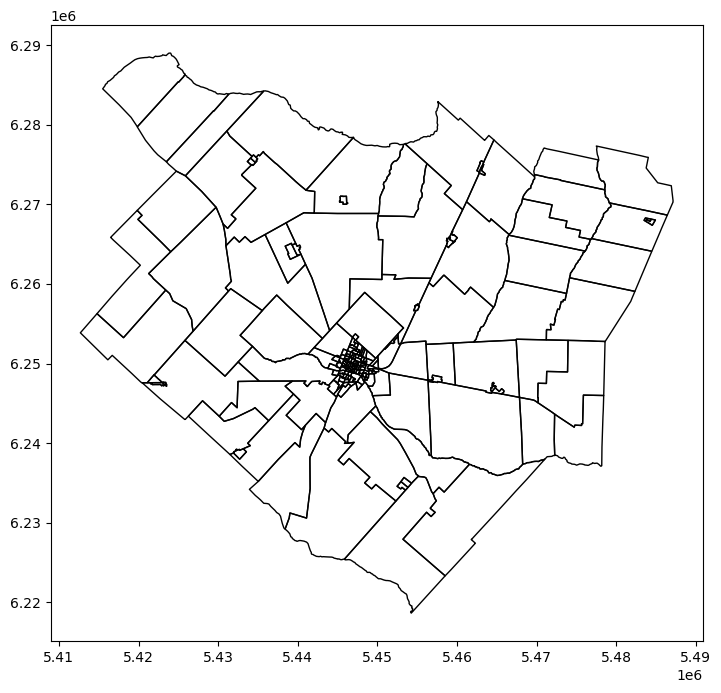

In [352]:
# Elimino todas las variables excepto su geometría
radios_censales = radios_censales[['geometry']]


# Muestra visualización simple
radios_censales.plot(edgecolor='k', facecolor='none', figsize=(10, 8))

In [353]:
radios_censales

geometry
0    POLYGON ((5446235.333 6250570.066, 5446324.284...
1    POLYGON ((5447556.668 6249828.883, 5447516.477...
2    POLYGON ((5424098.301 6288857.555, 5424168.801...
3    POLYGON ((5426720.301 6285501.555, 5426910.301...
4    POLYGON ((5467694.473 6275306.261, 5469688.468...
..                                                 ...
173  POLYGON ((5450151.368 6249147.520, 5450160.012...
174  POLYGON ((5447477.773 6252085.861, 5447441.781...
175  POLYGON ((5446528.492 6250117.809, 5446486.054...
176  POLYGON ((5446621.402 6250736.120, 5446714.442...
177  POLYGON ((5439886.801 6264787.055, 5439915.801...

[178 rows x 1 columns]

#### Paso 1 - Inicialización

Utilizamos K-means para agrupar datos en clústeres y luego mostramos los resultados en un mapa donde se pueden observar los radios censales coloreados por clúster y los centroides de cada clúster en azul. Esto facilita la visualización y comprensión de cómo se agrupan los datos geoespaciales en diferentes clústeres.

<Axes: >

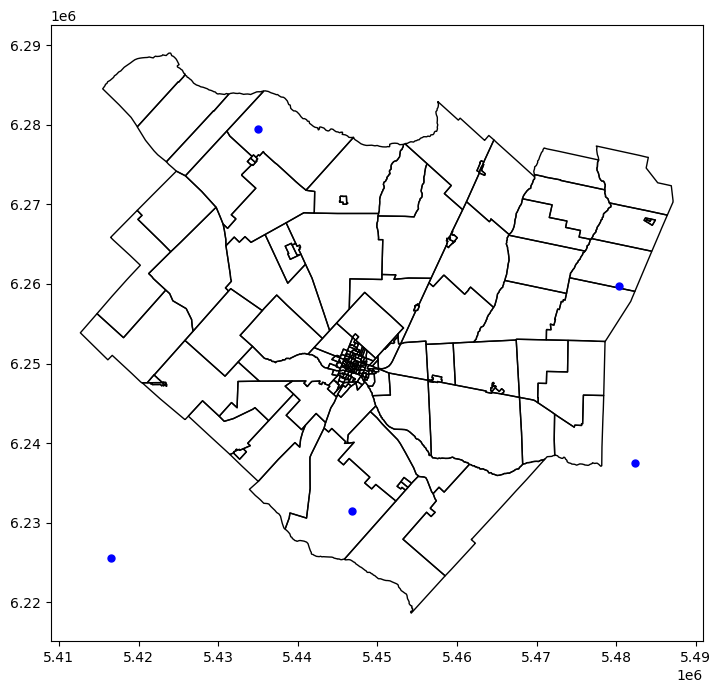

In [354]:
import random

# Cantidad de clúster a formar
num_cluster = 5

# Se generan tantos puntos aleatorios como clúster se quieran crear
## Para ello se establecen límites de radios
limites = radios_censales.total_bounds

## Se genera un listado aleatorio de coordenadas dentro de los límites
puntos_aleatorios = [(random.uniform(limites[0], limites[2]), random.uniform(limites[1], limites[3])) for i in range(num_cluster)]
puntos_aleatorios

## Se crean las geometrías a partir de las coordenadas
from shapely.geometry import Point
geometrias_puntos = [Point(x, y) for x, y in puntos_aleatorios]

## Se crea un GeoDataFrame con las geometrías de punto (centroides de clústers)
centroides_clusters = gpd.GeoDataFrame(geometry=geometrias_puntos, crs=radios_censales.crs)

## Creamos un identificador para cada punto
centroides_clusters['cluster'] = centroides_clusters.index

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='k', facecolor='none', figsize=(10, 8))
centroides_clusters.plot(ax=ax, color='blue', markersize=25)

In [355]:
centroides_clusters

geometry  cluster
0  POINT (5434962.284 6279465.933)        0
1  POINT (5446757.083 6231472.769)        1
2  POINT (5480376.950 6259687.292)        2
3  POINT (5416524.345 6225640.066)        3
4  POINT (5482346.481 6237450.153)        4

#### Paso 2 - Asignación de Observaciones

Calculamos las distancias entre los radios censales y los centroides de clústeres, luego visualizamos los resultados en un mapa que muestra las conexiones y la asignación de clústeres a cada radio censal.


Text(0.5, 1.0, 'Gráfico 2')

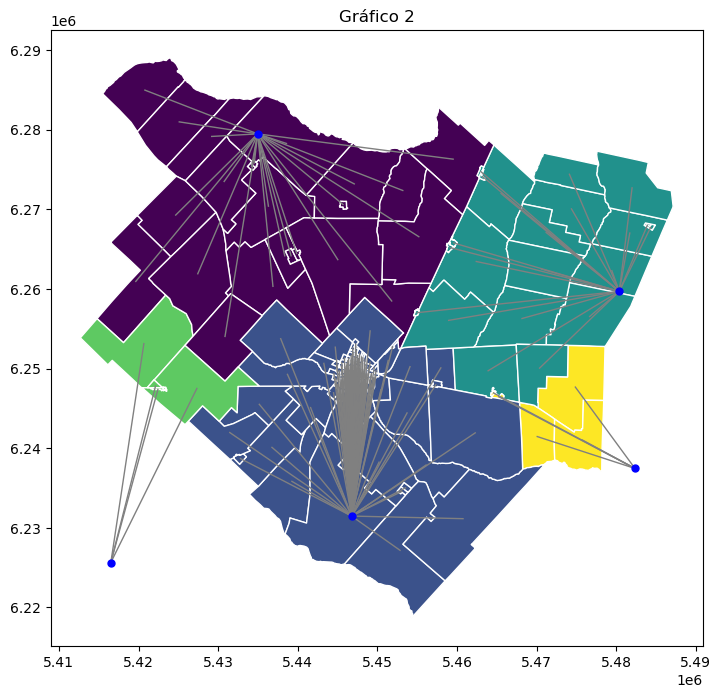

In [356]:
## Reutilizamos el cálculo de distancia de la clase 6 con algunas modificaciones
from shapely.ops import nearest_points
from shapely.geometry import LineString

# Crear una lista para almacenar las distancias al clúster más cercano
conexiones = []

# Iterar sobre los radios_censales y calcular la distancia al clúster más cercano
for idx, radio in radios_censales.iterrows():
    radio_geom = radio.geometry.centroid
    centroide_mas_cercana_idx = nearest_points(radio_geom, centroides_clusters.unary_union)[1]
    centroide_mas_cercana = centroides_clusters[centroides_clusters.geometry == centroide_mas_cercana_idx].iloc[0]
    etiqueta_centroide_cercana = centroide_mas_cercana['cluster']
    radios_censales.at[idx, 'cluster'] = etiqueta_centroide_cercana
    linea_entre_puntos = LineString([radio_geom, centroide_mas_cercana_idx])
    conexiones.append(linea_entre_puntos)

# Convierte la lista de conexiones a un GeoDataFrame para visualizarla
conexiones_gdf = gpd.GeoDataFrame(geometry=conexiones, crs=radios_censales.crs)

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
conexiones_gdf.plot(ax=ax, color='gray', linewidth=1, zorder=1)
centroides_clusters.plot(ax=ax, color='blue', markersize=25, zorder=2)
plt.title('Gráfico 2')

Gráfico paso 2.- Cada color representa a que clúster se unio y cada cluster tiene un color distinto.
Las lineas son las conexiones entre el centroide del radio y el clúster de menor distancia

#### Paso 3 - Actualización de Centroides
Calculamos el promedio de coordenadas de cada clúster para eso podemos utilizar el método `dissolve` .
Gráfico 3.- En este paso K-means hace la actualizacion de centroides desplazando el punto desde la union de todas las lineas hacia el centro de masa de cada polygono. 

In [357]:
# Agrupar por el campo 'cluster' y calculamos el promedio de coordenadas

# En esta linea de codigo lo que haces es dissolve por la variable cluster generando un gran polygono por color
radios_censales_dissolve = radios_censales.dissolve(by='cluster') 
# Calculamos el centroide
reposicion_centroides_clusters = radios_censales_dissolve.centroid 
# lo convertimos en un dataframe
reposicion_centroides_clusters = gpd.GeoDataFrame({'geometry': reposicion_centroides_clusters}, crs=reposicion_centroides_clusters.crs) 


# Realizar una operación de unión 1 a 1 basada en un índice común
centroides_clusters = centroides_clusters.merge(reposicion_centroides_clusters, how='left', on='cluster')
centroides_clusters

geometry_x  cluster                       geometry_y
0  POINT (5434962.284 6279465.933)        0  POINT (5437743.773 6269104.477)
1  POINT (5446757.083 6231472.769)        1  POINT (5449109.542 6239968.814)
2  POINT (5480376.950 6259687.292)        2  POINT (5470442.266 6262432.577)
3  POINT (5416524.345 6225640.066)        3  POINT (5423794.590 6250549.817)
4  POINT (5482346.481 6237450.153)        4  POINT (5473870.313 6244192.676)

Como vemos en la tabla ahora tenemos dos geometrias, geometry_x son las coordenadas originales y 
geometry_y son las nuevas coordenadas indicándonos las nuevas posiciones de los puntos.

Text(0.5, 1.0, 'Gráfico 3')

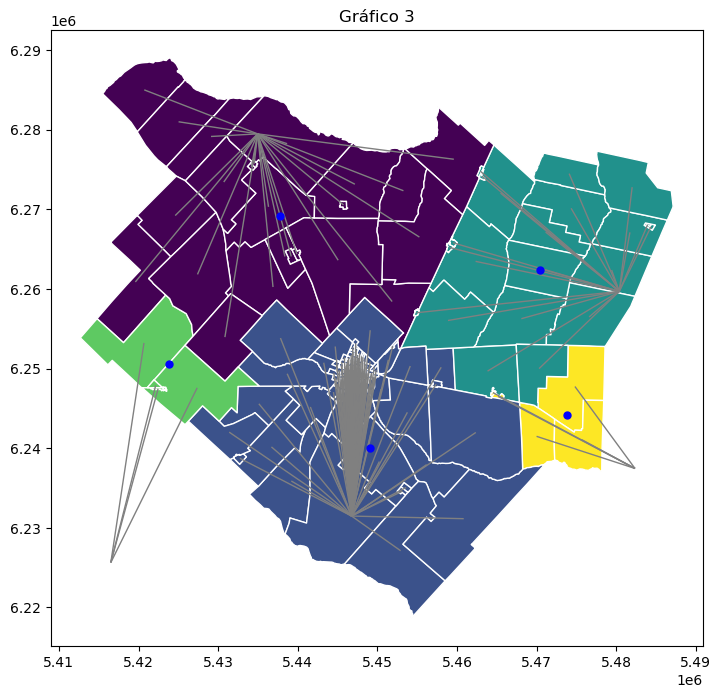

In [358]:
# Asignar las geometrías de los centroides a los puntos
centroides_clusters['geometry'] = centroides_clusters['geometry_y'].fillna(centroides_clusters['geometry_x'])

# Borrar las geometrías antiguas y setear de nuevo la geometry
centroides_clusters = centroides_clusters.drop(columns=['geometry_x','geometry_y'])
centroides_clusters = centroides_clusters.set_geometry('geometry')

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
conexiones_gdf.plot(ax=ax, color='gray', linewidth=1, zorder=1)
centroides_clusters.plot(ax=ax, color='blue', markersize=25, zorder=2)
plt.title('Gráfico 3')


Gráfico 3.- En este paso K-means hace la actualización de centroides desplazando el punto desde la unión de todas las líneas hacia el centro de masa de cada polygono.


#### Paso 4 - Reasignación de puntos
Reutilizamos el paso 2

Text(0.5, 1.0, 'Gráfico 4')

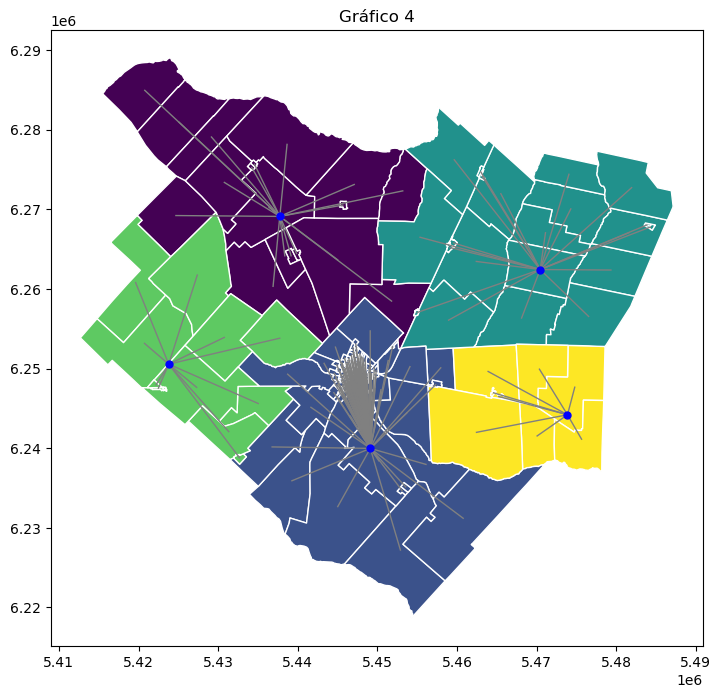

In [359]:
# Crear una lista para almacenar las distancias al clúster más cercano
conexiones = []

# Iterar sobre los radios_censales y calcular la distancia al clúster más cercano
for idx, radio in radios_censales.iterrows():
    radio_geom = radio.geometry.centroid
    centroide_mas_cercana_idx = nearest_points(radio_geom, centroides_clusters.unary_union)[1]
    centroide_mas_cercana = centroides_clusters[centroides_clusters.geometry == centroide_mas_cercana_idx].iloc[0]
    etiqueta_centroide_cercana = centroide_mas_cercana['cluster']
    radios_censales.at[idx, 'cluster'] = etiqueta_centroide_cercana
    linea_entre_puntos = LineString([radio_geom, centroide_mas_cercana_idx])
    conexiones.append(linea_entre_puntos)

# Convierte la lista de conexiones a un GeoDataFrame para visualizarla
conexiones_gdf = gpd.GeoDataFrame(geometry=conexiones, crs=radios_censales.crs)

# Mostramos ambos conjuntos de datos
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
conexiones_gdf.plot(ax=ax, color='gray', linewidth=1, zorder=1)
centroides_clusters.plot(ax=ax, color='blue', markersize=25, zorder=2)
plt.title('Gráfico 4')

Gráfico 4.- Vemos otra vez las conexiones al centroide

#### Paso 5 - Iteración
Comienza la iteración hasta que se cumplan los parámetros de convergencia.

### Aplicando K-means con sklearn
Sklearn trae una implementación de K-means para ser utilizada de manera muy práctica, la veremos a continuación:

In [360]:
# Volvemos a tomar la capa de radios censales y nos quedaremos con su geometría
radios_censales = radios_censales[['geometry']]

# Calculamos las coordenadas X e Y de su centroide
radios_censales['X'] = radios_censales.geometry.centroid.x
radios_censales['Y'] = radios_censales.geometry.centroid.y

# Creamos un DataFrame eliminando la columna geometry. Es necesario para aplicar KMeans
radios_censales_df = radios_censales.drop(columns='geometry')

# Mostramos el resultado
radios_censales_df

X             Y
0    5.446139e+06  6.250486e+06
1    5.447266e+06  6.249815e+06
2    5.420722e+06  6.284994e+06
3    5.425030e+06  6.280987e+06
4    5.465461e+06  6.272031e+06
..            ...           ...
173  5.449822e+06  6.249165e+06
174  5.447343e+06  6.252298e+06
175  5.446324e+06  6.249952e+06
176  5.446597e+06  6.250482e+06
177  5.439887e+06  6.264363e+06

[178 rows x 2 columns]

C:\Users\pim\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, 'Gráfico 5')

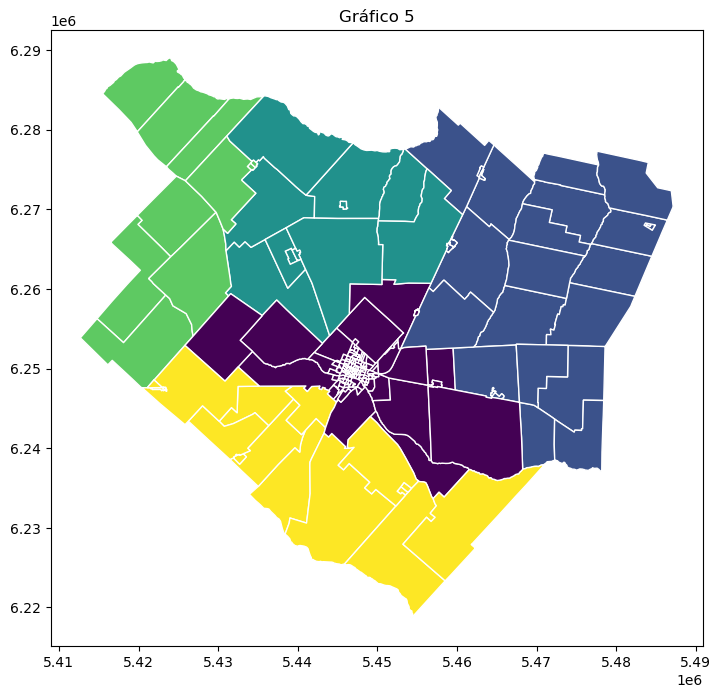

In [361]:
from sklearn.cluster import KMeans

# Cantidad de clúster a formar
num_cluster = 5

# Creamos el objeto KMeans con una configuración inicial
kmeans_radios = KMeans(n_clusters=num_cluster, n_init=1)

# Entrenamos y predecimos. Las clases se guardan en radios censales (GeoDataFrame)
radios_censales['cluster'] = kmeans_radios.fit_predict(radios_censales_df)

# Visualizamos el resultado
ax = radios_censales.plot(edgecolor='white', column='cluster', figsize=(10, 8), zorder=1)
plt.title('Gráfico 5')

Gráfico 5.- Podemos ver nuestra clusterización en 5 categorías